В этом ноутбуке будем предобратывать полученные данные и строить классификатор.

In [2]:
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import pymorphy2
import warnings
import scipy


from statsmodels.stats.weightstats import *
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC

# pd.set_option('display.max_rows', 650)
morph = pymorphy2.MorphAnalyzer()
warnings.simplefilter('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('train_data.csv')
df

,Достоинства,Недостатки,Комментарий,Рейтинг,Оценка комментария,Название телефона
0,"яркий экран, долгое время работы, производител...","сканер отпечатков пальцев, при искусственном о...",прекрасная модель за свои деньги. батарейки хв...,5.0,0.74,Samsung Galaxy A50 64GB
1,С учётом скидки на момент покупки и бонусов сп...,Много bloatware (раздутого софта). И есть прил...,Нисколечко не жалею о покупке смартфона. Это л...,4.0,0.73,Samsung Galaxy A50 64GB
2,"Очень удобный,шустрый,не подвисает . Я в восто...",не обнаружил,NaN,5.0,0.73,Samsung Galaxy A50 64GB
3,Шикарный,Нет,"Достойный, удобный, нет нареканий, всё есть чт...",5.0,0.61,Samsung Galaxy A50 64GB
4,Из достоинств: • Отличный экран • Много облегч...,"Из недостатков: • ""Слабенький"" экран в плане з...","Расписал я тут не всё, и далеко и очень доволе...",5.0,0.65,Samsung Galaxy A50 64GB
...,...,...,...,...,...,...
1040,Дизайн и сборка,"За 2015 год, клавиатура английская.\r Писать а...",Не для Российского рынка.,2.0,0.13,Nokia 230 Dual Sim
1041,Отличный кнопочный телефон. От нокиа.,Не,NaN,5.0,0.00,Nokia 230 Dual Sim
1042,"дарок, все функционирует, аккумулятор держит к...",NaN,NaN,5.0,0.00,Nokia 230 Dual Sim
1043,Бюджетно. Качественно. Как звонилка- хороший в...,"Думал, что заряда батареи будет хватать больше...",Хороший вариант резервного телефона. Звонит. П...,5.0,0.00,Nokia 230 Dual Sim


Посмотрим на общую информацию по датафрейму и всем признакам

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Достоинства         1024 non-null   object 
 1   Недостатки          939 non-null    object 
 2   Комментарий         806 non-null    object 
 3   Рейтинг             1045 non-null   float64
 4   Оценка комментария  1045 non-null   float64
 5   Название телефона   1045 non-null   object 
dtypes: float64(2), object(4)
memory usage: 49.1+ KB


Поставим метки классов. Среди комментариев пользователей есть не заполненые поля (NaN), заменим их на пустные строки и расставим метки классов.

In [5]:
df['y'] = np.where(df['Рейтинг'] > 3, 1, 0)
df['Достоинства'].fillna('', inplace=True)
df['Недостатки'].fillna('', inplace=True)
df['Комментарий'].fillna('', inplace=True)
df

,Достоинства,Недостатки,Комментарий,Рейтинг,Оценка комментария,Название телефона,y
0,"яркий экран, долгое время работы, производител...","сканер отпечатков пальцев, при искусственном о...",прекрасная модель за свои деньги. батарейки хв...,5.0,0.74,Samsung Galaxy A50 64GB,1
1,С учётом скидки на момент покупки и бонусов сп...,Много bloatware (раздутого софта). И есть прил...,Нисколечко не жалею о покупке смартфона. Это л...,4.0,0.73,Samsung Galaxy A50 64GB,1
2,"Очень удобный,шустрый,не подвисает . Я в восто...",не обнаружил,,5.0,0.73,Samsung Galaxy A50 64GB,1
3,Шикарный,Нет,"Достойный, удобный, нет нареканий, всё есть чт...",5.0,0.61,Samsung Galaxy A50 64GB,1
4,Из достоинств: • Отличный экран • Много облегч...,"Из недостатков: • ""Слабенький"" экран в плане з...","Расписал я тут не всё, и далеко и очень доволе...",5.0,0.65,Samsung Galaxy A50 64GB,1
...,...,...,...,...,...,...,...
1040,Дизайн и сборка,"За 2015 год, клавиатура английская.\r Писать а...",Не для Российского рынка.,2.0,0.13,Nokia 230 Dual Sim,0
1041,Отличный кнопочный телефон. От нокиа.,Не,,5.0,0.00,Nokia 230 Dual Sim,1
1042,"дарок, все функционирует, аккумулятор держит к...",,,5.0,0.00,Nokia 230 Dual Sim,1
1043,Бюджетно. Качественно. Как звонилка- хороший в...,"Думал, что заряда батареи будет хватать больше...",Хороший вариант резервного телефона. Звонит. П...,5.0,0.00,Nokia 230 Dual Sim,1


Посмотрим есть ли среди отзывов такие, у которых поля "Достоинства", "Недостатки", "Комментарий" все не заполнены.

In [6]:
df[(df['Достоинства'] == '') & (df['Недостатки'] == '') & (df['Комментарий'] == '')]

,Достоинства,Недостатки,Комментарий,Рейтинг,Оценка комментария,Название телефона,y
817,,,,5.0,-1.0,Philips Xenium E182,1


Удалим это надлюдение, оно для нас бесполезно

In [7]:
df = df[(df['Достоинства'] == '') & (df['Недостатки'] == '') & (df['Комментарий'] == '') == False]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1044
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Достоинства         1044 non-null   object 
 1   Недостатки          1044 non-null   object 
 2   Комментарий         1044 non-null   object 
 3   Рейтинг             1044 non-null   float64
 4   Оценка комментария  1044 non-null   float64
 5   Название телефона   1044 non-null   object 
 6   y                   1044 non-null   int32  
dtypes: float64(2), int32(1), object(4)
memory usage: 61.2+ KB


Рассмотрим как распределены метки целевого класса

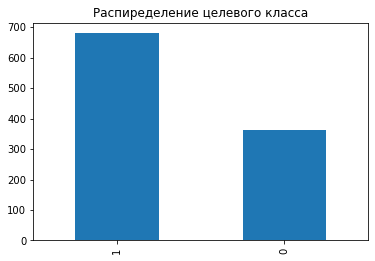

In [11]:
df['y'].value_counts().plot(kind='bar')
plt.title('Распиределение целевого класса')
plt.show()

Выведем относительное частоты целевого класса.

In [9]:
df['y'].value_counts(normalize=True)

1    0.651341
0    0.348659
Name: y, dtype: float64

Видим, что отношение классов далеко от 1:1, но этого может оказаться достаточно, чтобы построить разумную модель, балансировку классов проводить не будем.  

Считаем отзывы из файла для теста

In [10]:
f = open('test.csv', 'r', encoding='utf-8')
data = f.readlines()

test_list = []
for i in range(len(data)):
    if data[i][:8] == '<review>':
        tmp = data[i][8:].replace("\n", " ")
    elif data[i] != '</review>\n':
        tmp += data[i].replace("\n", " ")
    else:
        test_list.append(tmp)
        continue

In [11]:
df_test = pd.DataFrame(test_list, columns=['text'])
df_test.head()

,text
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментариях К сожалению, факт пол..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."


Если внимательно почитать отзывы в тесте, то можно прийти к выводу, что это отзывы на телефоны 2009-2013 годов. Сегодня удобной раскладкой "QWERTY" никого не удивишь, скорее всего наоборот. Поэтому единственная надежда, это обучить модель на общих словах/словосочетаниях. Для этого очистим исходные тексты трэйна и теста от символов, не являющихся английскими или русскими буквами или цифрами. 

In [12]:
for nov in df.columns[:3]:
    df[nov] = df[nov].replace('[^а-яА-ЯёЁa-zA-Z0-9 ]', '', regex=True)
df.head()

,Достоинства,Недостатки,Комментарий,Рейтинг,Оценка комментария,Название телефона,y
0,яркий экран долгое время работы производительн...,сканер отпечатков пальцев при искусственном ос...,прекрасная модель за свои деньги батарейки хва...,5.0,0.74,Samsung Galaxy A50 64GB,1
1,С учётом скидки на момент покупки и бонусов сп...,Много bloatware раздутого софта И есть приложе...,Нисколечко не жалею о покупке смартфона Это лу...,4.0,0.73,Samsung Galaxy A50 64GB,1
2,Очень удобныйшустрыйне подвисает Я в восторге,не обнаружил,,5.0,0.73,Samsung Galaxy A50 64GB,1
3,Шикарный,Нет,Достойный удобный нет нареканий всё есть что н...,5.0,0.61,Samsung Galaxy A50 64GB,1
4,Из достоинств Отличный экран Много облегчающ...,Из недостатков Слабенький экран в плане защит...,Расписал я тут не всё и далеко и очень доволен...,5.0,0.65,Samsung Galaxy A50 64GB,1


In [13]:
df_test['text'] = df_test['text'].replace('[^а-яА-ЯёЁa-zA-Z0-9 ]', '', regex=True)
df_test.head()

,text
0,Ужасно слабый аккумулятор это основной минус э...
1,ценанадежностьнеубиваемостьдолго держит батаре...
2,подробнее в комментариях К сожалению факт поло...
3,я любительница громкой музыки Тише телефона у ...
4,Дата выпуска 2011 г емкость 1430 mAh техноло...


Так как наблюдений в трэйне не так много, а получать их более быстрым и деликатным образом я пока не научился, применим лемматизацию(приведение слов к их нормальной форме), чтобы уменьшить пространство признаков. 

In [14]:
def lemmatization(data):
    tmp = ''
    for nov in data.split():
        tmp += morph.parse(nov)[0].normal_form + ' '
    return  tmp[:-1]

In [15]:
for nov in df.columns[:3]:
    df[nov] = df[nov].apply(lemmatization) 
df.head()

,Достоинства,Недостатки,Комментарий,Рейтинг,Оценка комментария,Название телефона,y
0,яркий экран долгий время работа производительн...,сканер отпечаток палец при искусственный освещ...,прекрасный модель за свой деньга батарейка хва...,5.0,0.74,Samsung Galaxy A50 64GB,1
1,с учёт скидка на момент покупка и бонус спасиб...,много bloatware раздутый софт и есть приложени...,нисколечко не жалеть о покупка смартфон это хо...,4.0,0.73,Samsung Galaxy A50 64GB,1
2,очень удобныйшустрыйн подвисать я в восторг,не обнаружить,,5.0,0.73,Samsung Galaxy A50 64GB,1
3,шикарный,нет,достойный удобный нет нарекание всё есть что н...,5.0,0.61,Samsung Galaxy A50 64GB,1
4,из достоинство отличный экран много облегчать ...,из недостаток слабенький экран в план защита о...,расписать я тут не всё и далеко и очень доволь...,5.0,0.65,Samsung Galaxy A50 64GB,1


In [16]:
df_test['text'] = df_test['text'].apply(lemmatization)
df_test.head()

,text
0,ужасно слабый аккумулятор это основной минус э...
1,ценанадежностьнеубиваемостьдолго держать батар...
2,подробный в комментарий к сожаление факт полом...
3,я любительница громкий музыка тихий телефон у ...
4,дата выпуск 2011 г ёмкость 1430 mah технология...


Строить модель будем, используя логистическую регрессию с параметром solver равным 'sag'(стохастический средний градиент), так как он хорошо работает на больших данных и испольует регуляризацию L2, что после примения лемматизации вполне логично.

### Построим базовую модель

In [17]:
pipeline = Pipeline([("vectorizer", CountVectorizer()), 
                     ("classifier", LogisticRegression(solver='sag', penalty='l2', random_state=47))])

In [18]:
X = df.drop(columns=['Рейтинг', 'Оценка комментария', 'Название телефона', 'y']).apply(lambda x: ' '.join(x), axis=1)
y = df['y']
clf = pipeline.fit(X, y)
pred = clf.predict(df_test['text'])
clf.score(X, y)

0.9703065134099617

### Подбор паратетров CountVectorizer

In [19]:
result_df = pd.DataFrame({'threshold': [], 'size_df': [], 'ngram_range': [], 'min_df': [], 'max_df': [], 
                          'solver': [], 'penalty': [], 'score_train': []})

Будем смотреть как меняется качетсво от варьирования следующих параметров:
1. threshold - пороговое значение для поля "Оценка комментария"
2. ngram_range - границы n-граммы
3. min_df - минимальная частота слова в документе.
4. max_df - максимальная частота слова в документе.

Для начала поймем как влияет исключение из выборки тех комментарием, которым не были поставлены оценки другими пользователями.

In [20]:
np.random.seed(47)

for threshold in [-1.1, -1]:
    df_ = df[df['Оценка комментария'] > threshold].reset_index(drop=True)
    X = df_.drop(columns=['Рейтинг', 'Оценка комментария', 'Название телефона', 'y']).apply(lambda x: ' '.join(x), axis=1)
    y = df_['y']
    for ngram in [(1, 1), (1, 2), (1, 3)]:
        for min_df_ in range(0, 51, 5):
            for max_df_ in range(150, 1001, 50):
                pipeline = Pipeline([("vectorizer", CountVectorizer(ngram_range=ngram, min_df=min_df_, max_df=max_df_)), 
                                    ("classifier", LogisticRegression(solver='sag', penalty='l2'))])
                clf = pipeline.fit(X, y)
                result_df.loc[len(result_df)] = [threshold, df_.shape[0], ngram, min_df_, max_df_, 
                                                'sag', 'none', clf.score(X, y)] 

In [21]:
result_df.sort_values(by='score_train', ascending=False).head(25)

,threshold,size_df,ngram_range,min_df,max_df,solver,penalty,score_train
990,-1.0,1001.0,"(1, 3)",0.0,150.0,sag,none,1.000000
996,-1.0,1001.0,"(1, 3)",0.0,450.0,sag,none,1.000000
991,-1.0,1001.0,"(1, 3)",0.0,200.0,sag,none,1.000000
992,-1.0,1001.0,"(1, 3)",0.0,250.0,sag,none,1.000000
993,-1.0,1001.0,"(1, 3)",0.0,300.0,sag,none,1.000000
793,-1.0,1001.0,"(1, 2)",0.0,200.0,sag,none,1.000000
794,-1.0,1001.0,"(1, 2)",0.0,250.0,sag,none,1.000000
795,-1.0,1001.0,"(1, 2)",0.0,300.0,sag,none,1.000000
796,-1.0,1001.0,"(1, 2)",0.0,350.0,sag,none,1.000000
797,-1.0,1001.0,"(1, 2)",0.0,400.0,sag,none,1.000000


-1.1 -- для обучения используется вся выборки
-1.0 -- в обучении не участвуют наблюдени без оценки другими пользователями

<AxesSubplot:xlabel='score_train', ylabel='threshold'>

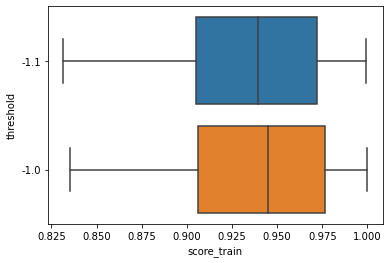

In [22]:
sns.boxplot(y="threshold", x="score_train", data=result_df, orient="h")

ОБЪЯСНИТЬ



Критерий Стьюдента:

$H_0\colon$ средние значения доли верных ответов у алгоритмов, которым подаются комметарии с оценкой и без них одинаковы.

$H_1\colon$ среднее занчение доля верных ответов у алгоритмов, которым подаются данные без оценки, меньше.

In [23]:
scipy.stats.ttest_ind(result_df[result_df['threshold'] == -1.1]['score_train'], 
                      result_df[result_df['threshold'] == -1]['score_train'], 
                     equal_var=False, alternative='less')

Ttest_indResult(statistic=-1.6017028149011638, pvalue=0.05474382156694148)

Нулевую гипотезу отклонить на уровне значимости 0.05 нельзя, поэтому в дальнешем будем учитывать эти наблюдения. Заменим значения этих наблюдений на среднее по столбцу без учета наблюдений с меткой -1(без оценки).

In [24]:
df['Оценка комментария'] = np.where(df['Оценка комментария'] == -1, 
                                    round(df[df['Оценка комментария'] != -1]['Оценка комментария'].mean(), 2),  
                                    df['Оценка комментария'])

Далее попробуем фильтровать комментарии по полю "Оценка комментария" и оценим как это влияет на качество, так же будем варьировать остальные параметры и выберем оптимальное сочетания для дальнейшей работы.

Выбирем в качетсве шага с которым будем установаливать порог для "Оценки комментария" межквартельный размах (МКР). Для этого нужно расчитать разность между 75% и 25% процентелями. Способы расчета МКР представлены в файле "MKR.pdf". Я использовал способ №3.

In [25]:
list_threshold = sorted(df['Оценка комментария'].unique())
R25 = 25 / 100 * (len(list_threshold) + 1)
Q25 = (list_threshold[int(R25) + 1] - list_threshold[int(R25)]) * (R25 - int(R25)) + list_threshold[int(R25)]
R75 = 75 / 100 * (len(list_threshold) + 1)
Q75 = (list_threshold[int(R75) + 1] - list_threshold[int(R75)]) * (R75 - int(R75)) + list_threshold[int(R75)]
step  = (Q75 - Q25) / pow(len(list_threshold), 1 / 3)

In [26]:
step

0.09929931645190113

In [27]:
np.random.seed(47)

result_df = pd.DataFrame({'threshold': [], 'size_df': [], 'ngram_range': [], 'min_df': [], 'max_df': [], 
                          'solver': [], 'penalty': [], 'score_train': []})

for threshold in np.arange(0, 1, step):
    df_ = df[df['Оценка комментария'] >= threshold].reset_index(drop=True)
    X = df_.drop(columns=['Рейтинг', 'Оценка комментария', 'Название телефона', 'y']).apply(lambda x: ' '.join(x), axis=1)
    y = df_['y']
    for ngram in [(1, 1), (1, 2), (1, 3)]:
        for min_df_ in range(0, 51, 5):
            for max_df_ in range(150, 1001, 50):
                pipeline = Pipeline([("vectorizer", CountVectorizer(ngram_range=ngram, min_df=min_df_, max_df=max_df_)), 
                                    ("classifier", LogisticRegression(solver='sag', penalty='l2'))])
                clf = pipeline.fit(X, y)

                result_df.loc[len(result_df)] = [threshold, df_.shape[0], ngram, min_df_, max_df_, 
                                                'sag', 'none', clf.score(X, y)] 

In [28]:
result_df.sort_values(by='score_train', ascending=False).head(25)

,threshold,size_df,ngram_range,min_df,max_df,solver,penalty,score_train
5552,0.893694,231.0,"(1, 2)",0.0,550.0,sag,none,1.0
6337,0.992993,203.0,"(1, 3)",0.0,200.0,sag,none,1.0
6345,0.992993,203.0,"(1, 3)",0.0,600.0,sag,none,1.0
6344,0.992993,203.0,"(1, 3)",0.0,550.0,sag,none,1.0
6343,0.992993,203.0,"(1, 3)",0.0,500.0,sag,none,1.0
6342,0.992993,203.0,"(1, 3)",0.0,450.0,sag,none,1.0
6341,0.992993,203.0,"(1, 3)",0.0,400.0,sag,none,1.0
6340,0.992993,203.0,"(1, 3)",0.0,350.0,sag,none,1.0
6339,0.992993,203.0,"(1, 3)",0.0,300.0,sag,none,1.0
6338,0.992993,203.0,"(1, 3)",0.0,250.0,sag,none,1.0


<AxesSubplot:xlabel='score_train', ylabel='threshold'>

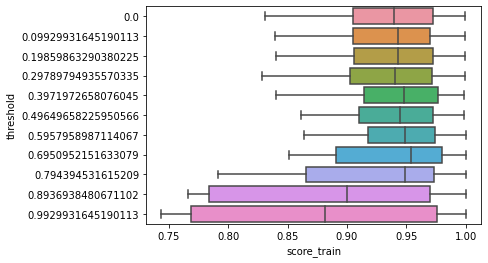

In [29]:
sns.boxplot(y="threshold", x="score_train", data=result_df, orient="h")

In [30]:
result_df.groupby(by='threshold')['score_train', 'size_df'].agg({'score_train': ['mean', 'median', 'min', 'max'], 
                                                                 'size_df': 'max'})

score_train                               size_df
                 mean    median       min       max     max
threshold                                                  
0.000000     0.936040  0.939176  0.831418  0.999042  1044.0
0.099299     0.938388  0.943114  0.839321  0.999002  1002.0
0.198599     0.939234  0.943262  0.839919  0.998987   987.0
0.297898     0.936743  0.940439  0.828631  0.998955   957.0
0.397197     0.944536  0.947964  0.840498  0.998869   884.0
0.496497     0.941863  0.944717  0.861179  0.998771   814.0
0.595796     0.942774  0.948995  0.863988  1.000000   647.0
0.695095     0.934760  0.954048  0.851204  1.000000   457.0
0.794395     0.916438  0.949254  0.791045  1.000000   335.0
0.893694     0.889486  0.900433  0.766234  1.000000   231.0
0.992993     0.874475  0.881773  0.743842  1.000000   203.0

По приведенному графику и вычисленным статистикам видно, что самые устойчивые результаты был достигнуты на наблюдениеях у которых 'threshold' больше или равно 0.198599 и при этом мы не потеряем много наблюдений. Далее выберем n-грамму

<AxesSubplot:xlabel='score_train', ylabel='ngram_range'>

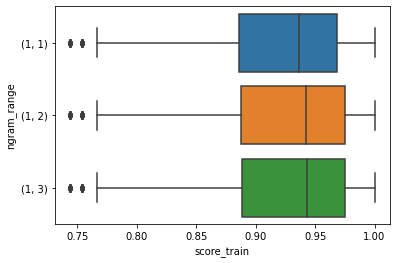

In [31]:
sns.boxplot(y="ngram_range", x="score_train", data=result_df[result_df['threshold'] >= 0.198599], orient="h")

In [32]:
result_df[result_df['threshold'] >= 0.198599].groupby(by='ngram_range')['score_train'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
ngram_range,,,,
"(1, 1)",0.919260,0.936631,0.743842,1.0
"(1, 2)",0.924305,0.942529,0.743842,1.0
"(1, 3)",0.924339,0.942906,0.743842,1.0


Выбираем n-граммы (1, 3). Далее выберем min_df (минимальная частота слова в документе).

<AxesSubplot:xlabel='score_train', ylabel='min_df'>

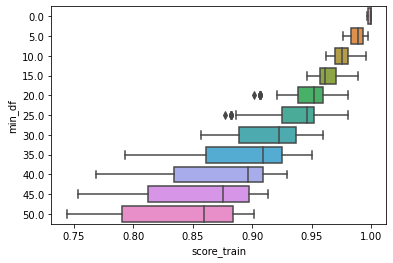

In [33]:
sns.boxplot(y="min_df", x="score_train", data=result_df[(result_df['threshold'] >= 0.198599) & 
                                                        (result_df['ngram_range'] == (1, 3))], orient="h")

In [34]:
result_df[(result_df['threshold'] >= 0.198599) & (result_df['ngram_range'] == (1, 3))].groupby(by='min_df')['score_train'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
min_df,,,,
0.0,0.998948,1.000000,0.996865,1.000000
5.0,0.988310,0.989059,0.975967,0.997812
10.0,0.976915,0.975369,0.962382,0.995624
15.0,0.963854,0.961039,0.945813,0.989059
20.0,0.947676,0.952239,0.901478,0.980769
25.0,0.935222,0.945701,0.876847,0.980306
30.0,0.912169,0.922153,0.857143,0.959815
35.0,0.889887,0.909091,0.793103,0.950541
40.0,0.866472,0.896498,0.768473,0.928903


Видим, что при min_df равным 0 очень многие модели смогли давать 100% долю верных ответов, но скорее всего для тестовых данных эта тендеция не сохранится (мы переобучимся), поэтому возьмем следующее по качесвту ограничение, т.е. min_df=5.

<AxesSubplot:xlabel='score_train', ylabel='max_df'>

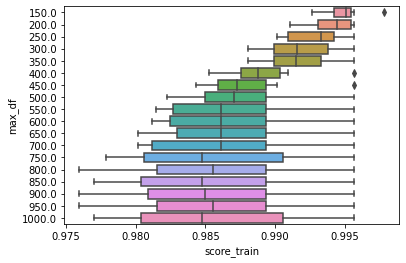

In [35]:
sns.boxplot(y="max_df", x="score_train", data=result_df[(result_df['threshold'] >= 0.198599) & 
                                        (result_df['ngram_range'] == (1, 3)) & (result_df['min_df'] == 5)], orient="h")

In [36]:
result_df[(result_df['threshold'] >= 0.198599) & 
          (result_df['ngram_range'] == (1, 3)) & 
          (result_df['min_df'] == 5)].groupby(by='max_df')['score_train'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
max_df,,,,
150.0,0.995008,0.995080,0.992685,0.997812
200.0,0.994067,0.994466,0.991045,0.995671
250.0,0.992916,0.993324,0.990148,0.995671
300.0,0.991890,0.991612,0.988060,0.995671
350.0,0.991594,0.991521,0.988060,0.995671
400.0,0.989218,0.988782,0.985258,0.995671
450.0,0.988130,0.987243,0.984326,0.995671
500.0,0.987573,0.987075,0.982236,0.995671
550.0,0.986699,0.986111,0.981453,0.995671


Видим, что при max_df=150 достигается наилучшее качество, но 150 вхождений слова это слишком маленькое ограничение даже для 1000 наблюдений, попробуем взять ограничение 500. Теперь посмотрим как влияет на качество измнение параметра C - штраф регуляризации.

In [37]:
pipeline = Pipeline([("vectorizer", CountVectorizer(min_df=5, max_df=500, ngram_range=(1, 3))), 
                     ("classifier", LogisticRegression(solver='sag', penalty='l2', random_state=47))])

In [38]:
df[df['Оценка комментария'] >= 0.198599]

,Достоинства,Недостатки,Комментарий,Рейтинг,Оценка комментария,Название телефона,y
0,яркий экран долгий время работа производительн...,сканер отпечаток палец при искусственный освещ...,прекрасный модель за свой деньга батарейка хва...,5.0,0.74,Samsung Galaxy A50 64GB,1
1,с учёт скидка на момент покупка и бонус спасиб...,много bloatware раздутый софт и есть приложени...,нисколечко не жалеть о покупка смартфон это хо...,4.0,0.73,Samsung Galaxy A50 64GB,1
2,очень удобныйшустрыйн подвисать я в восторг,не обнаружить,,5.0,0.73,Samsung Galaxy A50 64GB,1
3,шикарный,нет,достойный удобный нет нарекание всё есть что н...,5.0,0.61,Samsung Galaxy A50 64GB,1
4,из достоинство отличный экран много облегчать ...,из недостаток слабенький экран в план защита о...,расписать я тут не всё и далеко и очень доволь...,5.0,0.65,Samsung Galaxy A50 64GB,1
...,...,...,...,...,...,...,...
1035,у это экран 28 чуть большой чем у 225,один номер на контакт нельзя поставить разный ...,покупаться жена быть 225 разбить в хлам в рука...,5.0,0.33,Nokia 230 Dual Sim,1
1037,лёгкий долго держать зарядка удобный кнопк,,,5.0,0.65,Nokia 230 Dual Sim,1
1038,надёжный как всё телефон этот фирма,на задний крышка телефон лейбл царапать рука,модель удобный экран яркий звук замечательный ...,5.0,0.65,Nokia 230 Dual Sim,1
1039,экранчик большой кнопка дизайн немного похоже ...,цена завысить плэйер не очень удобный меню не ...,можно взять ради дизайн и логотип но не дорого...,4.0,0.65,Nokia 230 Dual Sim,1


In [39]:
threshold

0.9929931645190113

In [41]:
np.random.seed(47)

result_df = pd.DataFrame({'solver': [], 'penalty': [], 'C': [], 'score_train': []})
df_ = df[df['Оценка комментария'] >= 0.198599].reset_index(drop=True)
X = df_.drop(columns=['Рейтинг', 'Оценка комментария', 'Название телефона', 'y']).apply(lambda x: ' '.join(x), axis=1)
y = df_['y']
for c in np.arange(0.1, 2.1, 0.1):
    pipeline = Pipeline([("vectorizer", CountVectorizer(min_df=5, max_df=500, ngram_range=(1, 3))), 
                     ("classifier", LogisticRegression(solver='sag', penalty='l2', random_state=47))])

    clf = pipeline.fit(X, y)

    result_df.loc[len(result_df)] = ['sag', 'l2', c, clf.score(X, y)] 

In [42]:
result_df

,solver,penalty,C,score_train
0,sag,l2,0.1,0.981763
1,sag,l2,0.2,0.981763
2,sag,l2,0.3,0.981763
3,sag,l2,0.4,0.981763
4,sag,l2,0.5,0.981763
5,sag,l2,0.6,0.981763
6,sag,l2,0.7,0.981763
7,sag,l2,0.8,0.981763
8,sag,l2,0.9,0.981763
9,sag,l2,1.0,0.981763


Выбор размера штрафа на трэйне не влияет на качество. Оставим его по умолчанию (C=1.0). Сформируем итоговый классификатор.

In [47]:
pipeline = Pipeline([("vectorizer", CountVectorizer(min_df=5, max_df=500, ngram_range=(1, 3))), 
                     ("classifier", LogisticRegression(solver='sag', penalty='l2', random_state=47))])

In [48]:
df = df[df['Оценка комментария'] >= 0.198599].reset_index(drop=True)
X = df.drop(columns=['Рейтинг', 'Оценка комментария', 'Название телефона', 'y']).apply(lambda x: ' '.join(x), axis=1)
y = df['y']
clf = pipeline.fit(X, y)
pred = clf.predict(df_test['text'])

Сформируем csv с нашими ответами, далее можно будет проверить правильность на kaggle. Алгоритм смог верно классифицировать 85% от общего числа отзывов. В принципе это хороший результат, так как, не смотря на неоднородность данных (обучение и тест), наша модель смогла обести обобщающую способность. 

In [49]:
ans = pd.DataFrame({'Id' : range(0, len(pred)), 'y' : pred})
ans['y'] = np.where(ans['y'] == 1, 'pos', 'neg')
ans.to_csv('predict\'s.csv', index=False)

Сохраним наш обученный классификатор в виде Python объекта

In [50]:
f = open('reviews_clf', 'wb')
pickle.dump(clf, f)
f.close()